In [1]:
import glob
import pandas as pd
import plotly.graph_objects as go
import re
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras_preprocessing import image
from tensorflow.keras import callbacks
import os 
import shutil
img_height=224
img_width=224

In [2]:
# traning data handle
data_path='../input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train'
data=[]
for folder_path in glob.glob('{}/*'.format(data_path)):
    label=folder_path.split('/')[-1]
    for file_path in glob.glob('{}/*.jpg'.format(folder_path)):
        data.append([file_path,label])
df = pd.DataFrame(columns=['filepath', 'label'], data=data)
df.to_csv('data.csv',index=False)
df.head()

,filepath,label
0,../input/classification-of-plants-of-southeast...,passiflora
1,../input/classification-of-plants-of-southeast...,passiflora
2,../input/classification-of-plants-of-southeast...,passiflora
3,../input/classification-of-plants-of-southeast...,passiflora
4,../input/classification-of-plants-of-southeast...,passiflora


In [3]:
# draw a histogram of the labels
fig=go.Figure(data=[go.Histogram(x=df['label'],xbins=dict(start=0,end=26,size=1))])
fig.update_layout(title='Histogram of labels')
fig.show()

In [4]:
max_size= 1600


sample_list=[]
groups=df.groupby('label')
for label in df['label'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
# draw a histogram of the labels
fig=go.Figure(data=[go.Histogram(x=df['label'],xbins=dict(start=0,end=26,size=1))])
fig.update_layout(title='Histogram of labels')
fig.show()

In [5]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['label'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['sugarpalm', 'passiflora', 'mangosteen', 'zodia', 'starfruit', 'frangipani', 'durian', 'waterguava', 'vanilla', 'dragonfruit', 'guava', 'nilam', 'mango', 'lychee', 'coffeearabica', 'taro', 'whitepepper', 'bamboo', 'jackfruit', 'suweg', 'cinnamon', 'cacao', 'snakefruit', 'banana', 'papaya', 'sawo']


In [6]:
target = max_size
gen=ImageDataGenerator(horizontal_flip=True,
                       rotation_range=20,
                       width_shift_range=.2,
                       height_shift_range=.2,
                       zoom_range=.2)
groups=df.groupby('label')
for label in df['label'].unique():  # for every class            
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepath', y_col=None, target_size=(img_height,img_width), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 1355 validated image filenames.
Found 1167 validated image filenames.
Found 1222 validated image filenames.
Found 1191 validated image filenames.
Found 1409 validated image filenames.
Found 1242 validated image filenames.
Found 1116 validated image filenames.
Found 1256 validated image filenames.
Found 1341 validated image filenames.
Found 1224 validated image filenames.
Found 1588 validated image filenames.
Found 1336 validated image filenames.
Found 1567 validated image filenames.
Found 1343 validated image filenames.


In [7]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepath')
Lseries=pd.Series(aug_labels, name='label')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
balance_df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
balance_df=balance_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
print ('length of df is: ', len(df)) 

# draw a histogram of the labels
fig=go.Figure(data=[go.Histogram(x=balance_df['label'],xbins=dict(start=0,end=26,size=1))])
fig.update_layout(title='Histogram of labels')
fig.show()

length of aug_df"  4043
length of df is:  37557


In [8]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):    
    print("Name:", gpu.name, "  Type:", gpu.device_type)
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)

Name: /physical_device:GPU:0   Type: GPU


2022-04-10 02:42:49.331398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 02:42:49.426598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 02:42:49.427360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


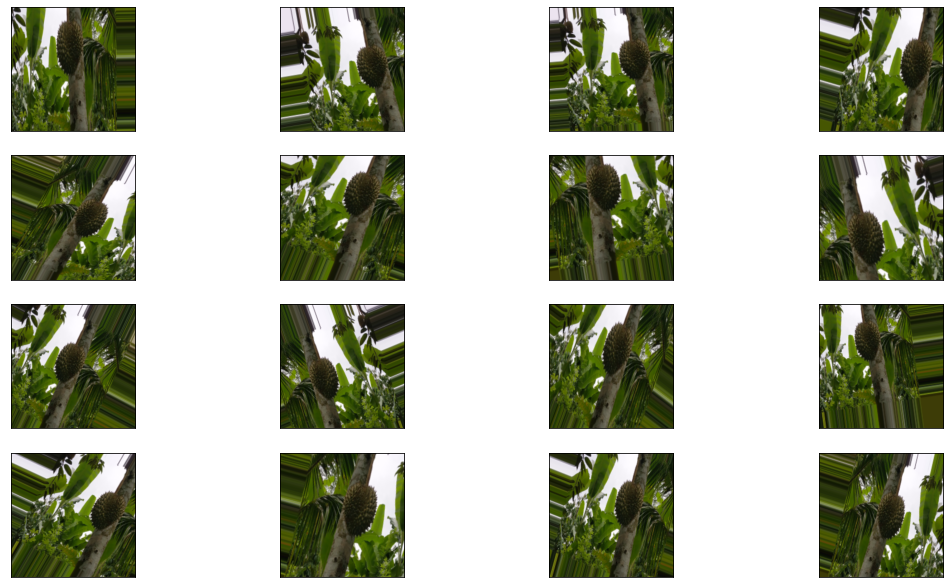

In [9]:
# ImageDataGenerator
train_data_dir='../input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train'
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2 # set validation split
                                  ) 
# preview the train_datagen image
pic=image.load_img('../input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/durian/10022.jpg')
pic=pic.resize((img_height,img_width))
pic_arr=image.img_to_array(pic)
pic_arr=pic_arr.reshape((1,)+pic_arr.shape)
num_img=4
fig=plt.figure(figsize=(num_img,num_img))
fig.set_size_inches(18.5, 10.5)
count=0
for b in train_datagen.flow(pic_arr):
    plt.subplot(num_img,num_img,count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b[0])
    count+=1
    if count==num_img*num_img:
        break
plt.show()



In [10]:
# load data
train_generator = train_datagen.flow_from_dataframe(
    balance_df,
    x_col='filepath', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical',
    shuffle=True,
    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_dataframe(
    balance_df,
    x_col='filepath', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical',
    subset='validation')  # set as validation data


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

Found 33280 validated image filenames belonging to 26 classes.
Found 8320 validated image filenames belonging to 26 classes.


In [11]:
print(train_generator.samples,len(train_generator))
print(train_generator.samples//batch_size)
print(type(train_generator))

33280 520
520
<class 'keras.preprocessing.image.DataFrameIterator'>


(64, 224, 224, 3)
(64, 26)
mango
0.0 1.0


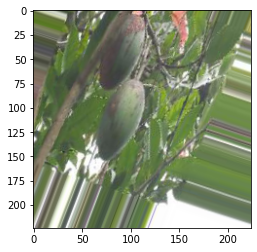

In [12]:
# xem thu data
img, label = train_generator.next()
print(img.shape)
print(label.shape)
plt.imshow(img[0])
print(labels[np.argmax(label[0])])
print(np.min(img),np.max(img))

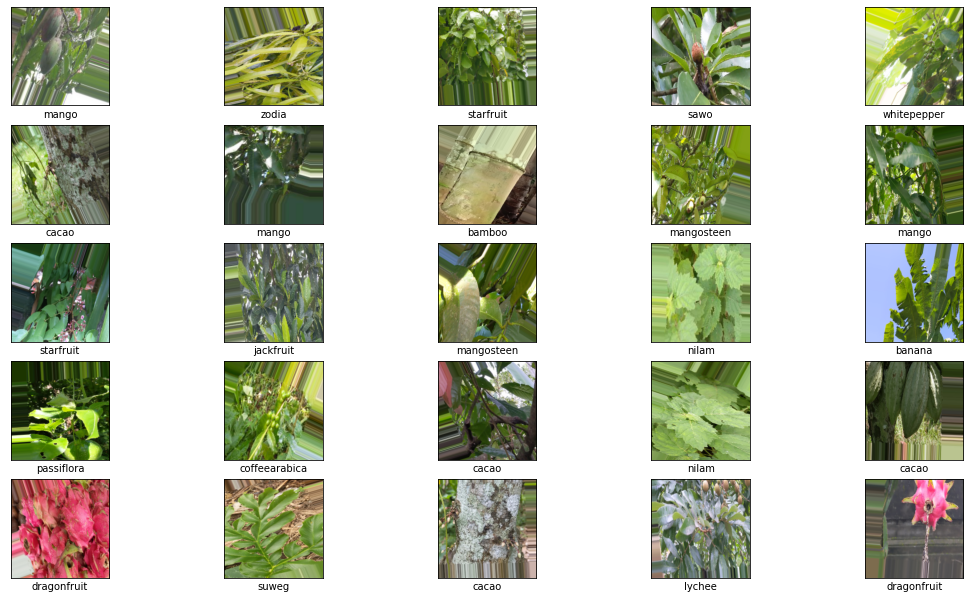

In [13]:
# preview image
fig=plt.figure(figsize=(5,5))
fig.set_size_inches(18.5, 10.5)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i%batch_size])
    plt.xlabel(labels[np.argmax(label[i%batch_size])])
    if (i%batch_size==0):
        img, label = train_generator.next()
plt.show()

In [14]:
def createCNNModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    # 26 category
    model.add(layers.Dense(26,activation='softmax'))
    model.summary()
    model.compile(optimizer ="adam",                
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    return model


In [15]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=True,
    weights=None,
    input_shape=(img_height, img_width, 3),
    classes=26,
    classifier_activation='softmax',
)
model.compile(optimizer ="adam",                
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

2022-04-10 02:43:49.387920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-10 02:43:49.388871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 02:43:49.389699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 02:43:49.390415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [16]:
# model=createCNNModel()
#model=createVGG16Model()

In [17]:
## let train =))
epochs=10
history = model.fit(train_generator,
                          epochs=epochs,
                          validation_data=validation_generator,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1,restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1, min_lr=0.00001)
                    ]
                        )


2022-04-10 02:43:58.360560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-10 02:44:17.138696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


520/520 [==============================] - 1577s 3s/step - loss: 1.0898 - accuracy: 0.6733 - val_loss: 2.6109 - val_accuracy: 0.4013
Epoch 2/10
520/520 [==============================] - 1397s 3s/step - loss: 0.3319 - accuracy: 0.8959 - val_loss: 0.7727 - val_accuracy: 0.7645
Epoch 3/10
520/520 [==============================] - 1399s 3s/step - loss: 0.1861 - accuracy: 0.9410 - val_loss: 0.8151 - val_accuracy: 0.7754

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
520/520 [==============================] - 1399s 3s/step - loss: 0.0399 - accuracy: 0.9893 - val_loss: 0.0208 - val_accuracy: 0.9947
Epoch 5/10
520/520 [==============================] - 1421s 3s/step - loss: 0.0188 - accuracy: 0.9962 - val_loss: 0.0147 - val_accuracy: 0.9968
Epoch 6/10
520/520 [==============================] - 1421s 3s/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0.0116 - val_accuracy: 0.9970
Epoch 7/10
520/520 [==============================] - 1419s 3s/st

In [18]:
model.save('model.h5')

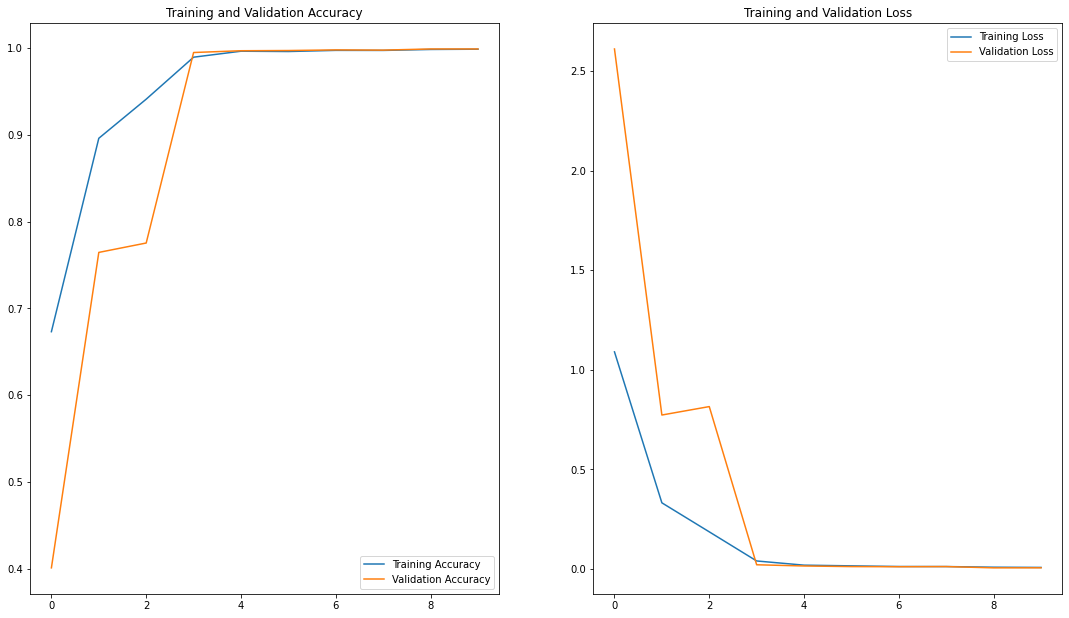

In [19]:
try:
    # summarize history 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    fig=plt.figure(figsize=(8, 8))
    fig.set_size_inches(18.5, 10.5)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
except:
    pass

[2.99295875e-12 4.64440708e-09 1.92005245e-07 7.70024156e-10
 4.49118831e-09 3.16993756e-08 6.01198813e-11 1.04083874e-07
 1.01566275e-05 2.91052009e-11 4.24317387e-11 6.45195564e-10
 2.87898400e-10 3.93995814e-09 2.51688698e-10 2.95620889e-10
 2.61626738e-08 5.12589916e-13 9.99989390e-01 1.83073973e-11
 7.30745409e-10 1.15683925e-08 1.21461374e-08 9.82651542e-08
 1.05321810e-11 1.16038610e-08]
starfruit


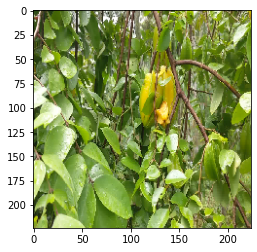

In [20]:
# predict the test for submission
folder_path='../input/classification-of-plants-of-southeast-asia/bali-26_test/bali-26_test'
images= glob.glob('{}/*.jpg'.format(folder_path))
submissions=[]

for image_file in images:
    img = image.load_img(image_file, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = x / 255.0
    x = x.reshape((1,)+x.shape)
    predict=model.predict(x)[0]
    
    idd=image_file.split('/')[-1]
    category=labels[np.argmax(predict)]
    submissions.append([idd,category])
df = pd.DataFrame(columns=['id', 'category'], data=submissions)
df.to_csv('submission.csv',index=False)
plt.imshow(img)
print(predict)
print(category)
